

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

In [1]:
import numpy as np

states = [0, 1, 2]
actions = [0, 1]

q_table = np.random.uniform(0, 100, size=(len(states), len(actions)))

In [2]:
current_state = 0
q_table[current_state]

array([82.02402676, 91.28226526])

In [3]:
q_table[current_state].argmax()

1

In [4]:
states = np.array([
    [0.5, 0.7],
    [1.2, 0.3],
    [-5.2, 0.1],
    [2.0, -3.0],
])

actions = [0, 1]

In [5]:
np.digitize(states[:, 0], bins=[-6, 0, 2])

array([2, 2, 1, 3], dtype=int64)

In [6]:
np.digitize(states, bins=[-6, 0, 4])

array([[2, 2],
       [2, 2],
       [1, 2],
       [2, 1]], dtype=int64)

In [7]:
import numpy as np

actions = [0, 1]

q_table = np.random.uniform(0, 100, size=(3, 3, len(actions)))

In [8]:
state = [1, 1]
q_table[1, 1]

array([29.7406627, 32.8769334])

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [x] Проверено на семинаре

In [9]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

env = gym.make('Blackjack-v1')

env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n, env.action_space

(32, 11, 2, Discrete(2))

In [10]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    print_every: int = 5000

In [11]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table()

    def _create_q_table(self):
        self.q_table = np.zeros((32, 11, 2, 2))

    def get_action(self, state: np.ndarray | tuple) -> int:
        player_sum, dealer_card, usable_ace = state
        q_values = self.q_table[player_sum, dealer_card, usable_ace]
        max_actions = np.flatnonzero(q_values == q_values.max())
        action = np.random.choice(max_actions)
        return action

    def update_q_table(
        self,
        state: np.ndarray | tuple,
        new_state: np.ndarray | tuple,
        reward: float, action: int,
        done: bool
    ) -> None:
        player_sum, dealer_card, usable_ace = state
        current_q_value = self.q_table[player_sum, dealer_card, usable_ace, action]     
        if done:
            future_q_value = 0
        else:
            new_player_sum, new_dealer_card, new_usable_ace = new_state
            future_q_value = np.max(self.q_table[new_player_sum, new_dealer_card, new_usable_ace])
        self.q_table[player_sum, dealer_card, usable_ace, action] = (
            (1 - self.cfg.lr) * current_q_value
            + self.cfg.lr * (reward + self.cfg.discount * future_q_value)
        )

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward


def train(self):
    ep_rewards = []  
    stats = []  

    wins = 0
    losses = 0
    draws = 0

    for ep in tqdm(range(self.cfg.n_episodes)):
        
        reward = self.run_episode()
        ep_rewards.append(reward)

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
        
        if (ep + 1) % self.cfg.print_every == 0:
            stats.append({
                "episode": ep + 1,
                "wins": wins,
                "losses": losses,
                "draws": draws,
                "win_rate": wins / self.cfg.print_every
            })
            print(stats[-1])
            wins = 0
            losses = 0
            draws = 0

    return ep_rewards, stats

In [12]:
env = gym.make('Blackjack-v1')

config = Config(
    discount=0.95,
    lr=0.005,
    n_episodes=10_000,
    print_every=1000
)

agent = Agent(env, config)

ep_rewards, stats = train(agent)

  0%|          | 0/10000 [00:00<?, ?it/s]

 21%|██        | 2059/10000 [00:00<00:01, 6768.13it/s]

{'episode': 1000, 'wins': 402, 'losses': 544, 'draws': 54, 'win_rate': 0.402}
{'episode': 2000, 'wins': 433, 'losses': 506, 'draws': 61, 'win_rate': 0.433}


 42%|████▏     | 4175/10000 [00:00<00:00, 6968.20it/s]

{'episode': 3000, 'wins': 414, 'losses': 510, 'draws': 76, 'win_rate': 0.414}
{'episode': 4000, 'wins': 393, 'losses': 540, 'draws': 67, 'win_rate': 0.393}


 62%|██████▏   | 6239/10000 [00:00<00:00, 6704.49it/s]

{'episode': 5000, 'wins': 379, 'losses': 539, 'draws': 82, 'win_rate': 0.379}
{'episode': 6000, 'wins': 398, 'losses': 526, 'draws': 76, 'win_rate': 0.398}


 83%|████████▎ | 8318/10000 [00:01<00:00, 6776.65it/s]

{'episode': 7000, 'wins': 399, 'losses': 516, 'draws': 85, 'win_rate': 0.399}
{'episode': 8000, 'wins': 434, 'losses': 485, 'draws': 81, 'win_rate': 0.434}


100%|██████████| 10000/10000 [00:01<00:00, 6813.61it/s]

{'episode': 9000, 'wins': 422, 'losses': 488, 'draws': 90, 'win_rate': 0.422}
{'episode': 10000, 'wins': 417, 'losses': 498, 'draws': 85, 'win_rate': 0.417}


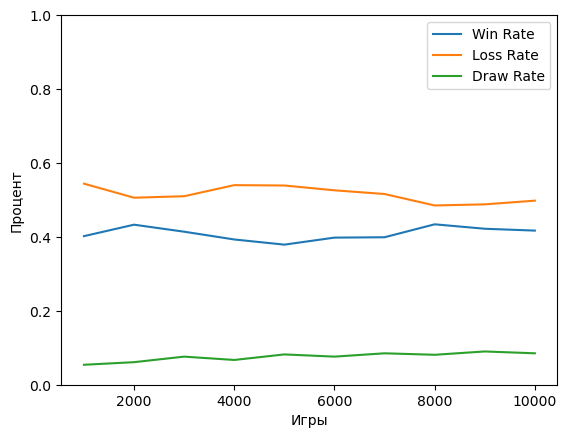

In [13]:
win_rates = [stat.get("win_rate", 0) for stat in stats]
losses_rates = [stat.get("losses", 0) / agent.cfg.print_every for stat in stats]
losses_rates = [stat.get("losses", 0) / agent.cfg.print_every for stat in stats]
draws_rates = [stat.get("draws", 0) / agent.cfg.print_every for stat in stats]

episodes = [stat.get("episode", 0) for stat in stats]

plt.ylim(0, 1)
plt.xlabel("Игры")
plt.ylabel("Процент")
plt.plot(episodes, win_rates, label="Win Rate")
plt.plot(episodes, losses_rates, label="Loss Rate")
plt.plot(episodes, draws_rates, label="Draw Rate")
plt.legend()
plt.show()

<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [x] Проверено на семинаре

In [14]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    epsilon: float = 1.0
    final_epsilon: float = 0.3
    print_every: int = 5000

In [15]:
class Agent:
    def __init__(self, env: gym.Env, config: Config, how) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table(how)

    def _create_q_table(self, how):
        if how == 'random':
            self.q_table = np.random.uniform(low=0, high=1, size=(32, 11, 2, 2))
        else:
            self.q_table = np.zeros((32, 11, 2, 2))
        

    def get_action(self, state: np.ndarray | tuple) -> int:
        p = np.random.rand()
        if p < self.cfg.epsilon:
            return self.env.action_space.sample()
        player_sum, dealer_card, usable_ace = state
        q_values = self.q_table[player_sum, dealer_card, usable_ace]
        return np.argmax(q_values)
    
    def update_q_table(
        self,
        state: np.ndarray | tuple,
        new_state: np.ndarray | tuple,
        reward: float, action: int,
        done: bool
    ) -> None:
        player_sum, dealer_card, usable_ace = state
        current_q_value = self.q_table[player_sum, dealer_card, usable_ace, action]     
        if done:
            future_q_value = 0
        else:
            new_player_sum, new_dealer_card, new_usable_ace = new_state
            future_q_value = np.max(self.q_table[new_player_sum, new_dealer_card, new_usable_ace])
        self.q_table[player_sum, dealer_card, usable_ace, action] = (
            (1 - self.cfg.lr) * current_q_value
            + self.cfg.lr * (reward + self.cfg.discount * future_q_value)
        )

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward


def train(self):
    ep_rewards = []  
    stats = []  

    wins = 0
    losses = 0
    draws = 0

    self.cfg.epsilon_decay = self.cfg.epsilon / self.cfg.n_episodes
    for ep in tqdm(range(self.cfg.n_episodes)):
        reward = self.run_episode()
        ep_rewards.append(reward)

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
        
        self.cfg.epsilon -= self.cfg.epsilon_decay

        if (ep + 1) % self.cfg.print_every == 0:
            stats.append({
                "episode": ep + 1,
                "wins": wins,
                "losses": losses,
                "draws": draws,
                "win_rate": wins / self.cfg.print_every
            })
            print(stats[-1])
            wins = 0
            losses = 0
            draws = 0

    return ep_rewards, stats

In [16]:
env = gym.make('Blackjack-v1')

config = Config(
    discount = 0.95,
    lr = 0.005,
    n_episodes = 10_000,
    epsilon = 1.0,
    final_epsilon = 0.3,
    print_every = 1000
)

agent = Agent(env, config, how='zeros')

ep_rewards, stats = train(agent)

 27%|██▋       | 2662/10000 [00:00<00:00, 8827.36it/s]

{'episode': 1000, 'wins': 289, 'losses': 666, 'draws': 45, 'win_rate': 0.289}
{'episode': 2000, 'wins': 302, 'losses': 639, 'draws': 59, 'win_rate': 0.302}


 45%|████▍     | 4462/10000 [00:00<00:00, 8913.11it/s]

{'episode': 3000, 'wins': 311, 'losses': 650, 'draws': 39, 'win_rate': 0.311}
{'episode': 4000, 'wins': 357, 'losses': 590, 'draws': 53, 'win_rate': 0.357}


 63%|██████▎   | 6261/10000 [00:00<00:00, 8904.40it/s]

{'episode': 5000, 'wins': 343, 'losses': 602, 'draws': 55, 'win_rate': 0.343}
{'episode': 6000, 'wins': 339, 'losses': 585, 'draws': 76, 'win_rate': 0.339}


 90%|████████▉ | 8958/10000 [00:01<00:00, 8938.31it/s]

{'episode': 7000, 'wins': 378, 'losses': 553, 'draws': 69, 'win_rate': 0.378}
{'episode': 8000, 'wins': 409, 'losses': 518, 'draws': 73, 'win_rate': 0.409}


100%|██████████| 10000/10000 [00:01<00:00, 8751.11it/s]

{'episode': 9000, 'wins': 414, 'losses': 514, 'draws': 72, 'win_rate': 0.414}
{'episode': 10000, 'wins': 437, 'losses': 500, 'draws': 63, 'win_rate': 0.437}


In [17]:
env = gym.make('Blackjack-v1')

config = Config(
    discount = 0.95,
    lr = 0.005,
    n_episodes = 10_000,
    epsilon = 1.0,
    final_epsilon = 0.3,
    print_every = 1000
)

agent = Agent(env, config, how='random')


ep_rewards, stats = train(agent)

 26%|██▌       | 2596/10000 [00:00<00:00, 8600.57it/s]

{'episode': 1000, 'wins': 277, 'losses': 675, 'draws': 48, 'win_rate': 0.277}
{'episode': 2000, 'wins': 267, 'losses': 690, 'draws': 43, 'win_rate': 0.267}


 44%|████▍     | 4411/10000 [00:00<00:00, 8876.76it/s]

{'episode': 3000, 'wins': 262, 'losses': 681, 'draws': 57, 'win_rate': 0.262}
{'episode': 4000, 'wins': 290, 'losses': 682, 'draws': 28, 'win_rate': 0.29}


 62%|██████▏   | 6201/10000 [00:00<00:00, 8830.66it/s]

{'episode': 5000, 'wins': 305, 'losses': 646, 'draws': 49, 'win_rate': 0.305}
{'episode': 6000, 'wins': 312, 'losses': 631, 'draws': 57, 'win_rate': 0.312}


 80%|███████▉  | 7999/10000 [00:00<00:00, 8894.15it/s]

{'episode': 7000, 'wins': 317, 'losses': 633, 'draws': 50, 'win_rate': 0.317}
{'episode': 8000, 'wins': 295, 'losses': 650, 'draws': 55, 'win_rate': 0.295}


100%|██████████| 10000/10000 [00:01<00:00, 8677.06it/s]

{'episode': 9000, 'wins': 331, 'losses': 610, 'draws': 59, 'win_rate': 0.331}
{'episode': 10000, 'wins': 342, 'losses': 588, 'draws': 70, 'win_rate': 0.342}


In [18]:
env = gym.make('Blackjack-v1')

config = Config(
    discount = 0.95,
    lr = 0.05,
    n_episodes = 10_000,
    epsilon = 0.3,
    final_epsilon = 0.05,
    print_every = 1000
)

agent = Agent(env, config, how='zeros')


ep_rewards, stats = train(agent)

 26%|██▌       | 2602/10000 [00:00<00:00, 8623.99it/s]

{'episode': 1000, 'wins': 326, 'losses': 598, 'draws': 76, 'win_rate': 0.326}
{'episode': 2000, 'wins': 391, 'losses': 538, 'draws': 71, 'win_rate': 0.391}


 43%|████▎     | 4314/10000 [00:00<00:00, 8409.70it/s]

{'episode': 3000, 'wins': 369, 'losses': 566, 'draws': 65, 'win_rate': 0.369}
{'episode': 4000, 'wins': 389, 'losses': 538, 'draws': 73, 'win_rate': 0.389}


 60%|█████▉    | 5985/10000 [00:00<00:00, 8186.73it/s]

{'episode': 5000, 'wins': 392, 'losses': 547, 'draws': 61, 'win_rate': 0.392}
{'episode': 6000, 'wins': 396, 'losses': 532, 'draws': 72, 'win_rate': 0.396}


 85%|████████▌ | 8542/10000 [00:01<00:00, 8397.58it/s]

{'episode': 7000, 'wins': 413, 'losses': 523, 'draws': 64, 'win_rate': 0.413}
{'episode': 8000, 'wins': 411, 'losses': 521, 'draws': 68, 'win_rate': 0.411}


100%|██████████| 10000/10000 [00:01<00:00, 8373.05it/s]

{'episode': 9000, 'wins': 410, 'losses': 496, 'draws': 94, 'win_rate': 0.41}
{'episode': 10000, 'wins': 423, 'losses': 497, 'draws': 80, 'win_rate': 0.423}


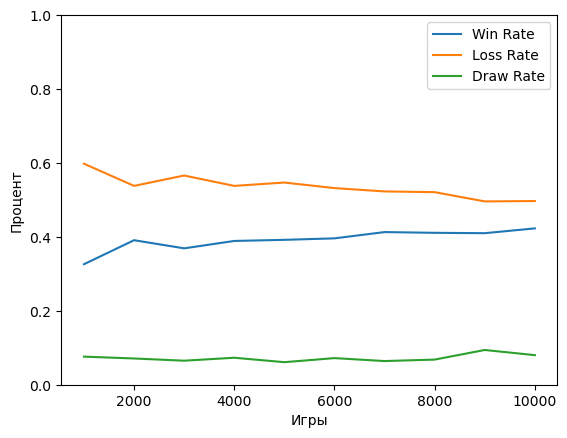

In [19]:
win_rates = [stat.get("win_rate", 0) for stat in stats]
losses_rates = [stat.get("losses", 0) / agent.cfg.print_every for stat in stats]
losses_rates = [stat.get("losses", 0) / agent.cfg.print_every for stat in stats]
draws_rates = [stat.get("draws", 0) / agent.cfg.print_every for stat in stats]

episodes = [stat.get("episode", 0) for stat in stats]

plt.ylim(0, 1)
plt.xlabel("Игры")
plt.ylabel("Процент")
plt.plot(episodes, win_rates, label="Win Rate")
plt.plot(episodes, losses_rates, label="Loss Rate")
plt.plot(episodes, draws_rates, label="Draw Rate")
plt.legend()
plt.show()